[View in Colaboratory](https://colab.research.google.com/github/rdenadai/Image-Study-Notebooks/blob/master/notebooks/madelbrot.ipynb)

## Mandelbrot


### Numba

Using **numba** one could get even better performance results, without changing much code. It's a excellent libray, with which you will out perform the simplest code.

Check out more about [numba](http://numba.pydata.org/)

In [1]:
!pip install numba

In [0]:
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numba import jit

%matplotlib inline

np.warnings.filterwarnings('ignore')

In [0]:
@lru_cache(maxsize=10)
def mandelbrot(edges=2, maxiter=100, size=None, dtype='normal', color=True):
    N = 1024
    if size is None:
        x1, x2, y1, y2 = -2, 1, -1.5, 1.5
    else:
        x1, x2, y1, y2 = size
    x, y = np.meshgrid(np.linspace(x1, x2, N), np.linspace(y1, y2, N))
    c = x + (1j * y)

    @jit(parallel=True)
    def normal(z, fractal):
        for n in range(maxiter):
            z = z**edges + c
            if color:
                fractal[(np.abs(z) > maxiter)] = n - (np.log(n) / np.log(2)) * .1
        return z, fractal

    @jit(parallel=True)
    def tricorn(z, fractal):
        for n in range(maxiter):
            z = z.conj()
            z = z**edges + c
            if color:
                fractal[(np.abs(z) > maxiter)] = n - (np.log(n) / np.log(2)) * .1
        return z, fractal
    
    @jit(parallel=True)
    def mb_sine(z, fractal):
        for n in range(maxiter):
            z = np.sin(z/c)
            if color:
                fractal[(np.abs(z) > maxiter)] = n - (np.log(n) / np.log(2)) * .1
        return z, fractal

    @jit(parallel=True)
    def mb_cosine(z, fractal):
        for n in range(maxiter):
            z = np.cos(z/c)
            if color:
                fractal[(np.abs(z) > maxiter)] = n - (np.log(n) / np.log(2)) * .1
        return z, fractal
    
    z = c.copy()
    fractal = np.zeros(z.shape, dtype=np.uint8)
    if dtype == 'normal':
        z, fractal = normal(z, fractal)
    elif dtype == 'tricorn':
        z, fractal = tricorn(z, fractal)
    elif dtype == 'sine':
        z, fractal = mb_sine(z, fractal)
    elif dtype == 'cosine':
        z, fractal = mb_cosine(z, fractal)

    if color:
        return (fractal**.3).astype(np.float64)
    return np.abs(z)

@lru_cache(maxsize=10)
def mandelbrot_colorless(edges=2, maxiter=100, size=None, dtype='normal', color=True):
    N = 1024
    if size is None:
        x1, x2, y1, y2 = -2, 1, -1.5, 1.5
    else:
        x1, x2, y1, y2 = size
    x, y = np.linspace(x1, x2, N), np.linspace(y1, y2, N)
    c = x[:, np.newaxis] + (1j * y[np.newaxis, :])

    z = c
    if dtype == 'normal':
        for _ in range(maxiter):
            z = z**edges + c
    elif dtype == 'tricorn':
        for _ in range(maxiter):
            z = z.conj()
            z = z**edges + c
    elif dtype == 'sine':
        for _ in range(maxiter):
            z = np.sin(z/c)
    elif dtype == 'cosine':
        for _ in range(maxiter):
            z = np.cos(z/c)
    return np.abs(z)

### Mandelbrot Set

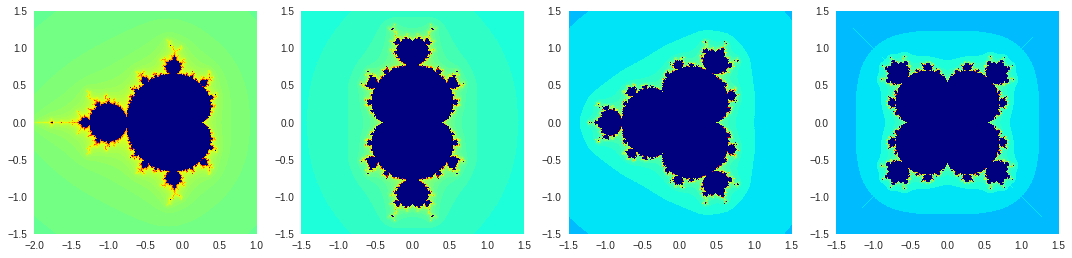

In [43]:
plt.figure(figsize=(15, 15))
for i in [2, 3, 4, 5]:
    plt.subplot(1, 4, i-1)
    size = (-1.5, 1.5, -1.5, 1.5)
    if i == 2:
        size = (-2, 1, -1.5, 1.5)
    mandel = mandelbrot(edges=i, size=size)
    plt.imshow(mandel, extent=size, cmap='jet')
    plt.grid(False)
plt.tight_layout()
plt.show()

### Tricorn

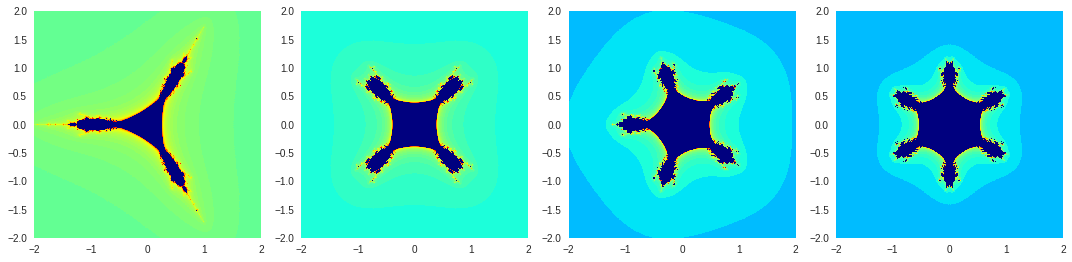

In [26]:
plt.figure(figsize=(15, 15))
for i in [2, 3, 4, 5]:
    plt.subplot(1, 4, i-1)
    mandel = mandelbrot(edges=i, size=(-2, 2, -2, 2), dtype='tricorn')
    plt.imshow(mandel, extent=[-2, 2, -2, 2], cmap='jet')
    plt.grid(False)
plt.tight_layout()
plt.show()

### Sine and Cosine

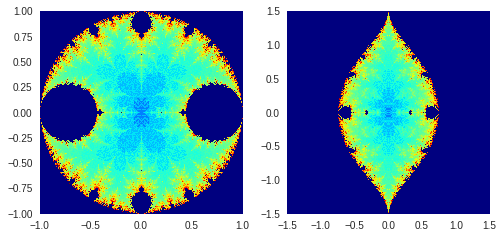

In [28]:
plt.figure(figsize=(7, 7))
mbscs = mandelbrot(size=(-1, 1, -1, 1), dtype='sine')
mbscc = mandelbrot(size=(-1.5, 1.5, -1.5, 1.5), dtype='cosine')

plt.subplot(1, 2, 1)
plt.imshow(mbscs, extent=[-1, 1, -1, 1], cmap='jet')
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(mbscc, extent=[-1.5, 1.5, -1.5, 1.5], cmap='jet')
plt.grid(False)
plt.tight_layout()
plt.show()

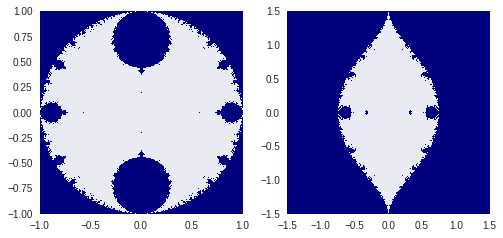

In [29]:
plt.figure(figsize=(7, 7))
mbscs = mandelbrot_colorless(size=(-1, 1, -1, 1), dtype='sine')
mbscc = mandelbrot_colorless(size=(-1.5, 1.5, -1.5, 1.5), dtype='cosine')

plt.subplot(1, 2, 1)
plt.imshow(mbscs, extent=[-1, 1, -1, 1], cmap='jet')
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(mbscc.T, extent=[-1.5, 1.5, -1.5, 1.5], cmap='jet')
plt.grid(False)
plt.tight_layout()
plt.show()

In [44]:
size = (-2, 1, -1.5, 1.5)

print('Mandelbrot with color:')
%timeit mandelbrot(edges=2, size=size)

print('Mandelbrot without color:')
%timeit mandelbrot_colorless(edges=2, size=size)

size = (-1, 1, -1, 1)

print('Mandelbrot sine with color:')
%timeit mandelbrot(edges=2, size=size, dtype='sine')

print('Mandelbrot sine without color:')
%timeit mandelbrot_colorless(edges=2, size=size, dtype='sine')

Mandelbrot with color:
The slowest run took 19.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 396 ns per loop
Mandelbrot without color:
The slowest run took 2699419.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 518 ns per loop
Mandelbrot sine with color:
The slowest run took 15652505.98 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 547 ns per loop
Mandelbrot sine without color:
The slowest run took 11739968.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 538 ns per loop


## Inefficient way

The bellow examples show mandelbrot calculation (and sine version), but they are very inefficient since we must pass through all positions of the multidimensional image.

But the computation of the colors, allow it to performe more fine grain distinction with a few drawbacks...

In [0]:
@lru_cache(maxsize=10)
def mandelbrot(size=2, maxiter=80):
    N = 500
    x, y = np.linspace(-2, 1, N), np.linspace(-1.25, 1.25, N) * 1j
    
    def mandelbrot_set(c, h, maxiter):
        z = c
        for n in range(maxiter):
            if np.abs(z) > h:
                return n - np.log(np.log(z)) / np.log(2)
            z = z**size + c
        return 0

    h = int(np.ceil(maxiter/2))
    ms = np.empty([N, N])
    for k in range(0, x.size):
        for l in range(0, x.size):
            ms[k, l] = mandelbrot_set(x[k] + y[l], h, maxiter)
    return np.nan_to_num(ms**.3)

@lru_cache(maxsize=10)
def mandelbrot_sine(maxiter=80):
    N = 500
    x, y = np.linspace(-1, 1, N), np.linspace(-1, 1, N) * 1j
    
    def mandelbrot_set(c, h, maxiter):
        z = c
        for n in range(maxiter):
            if np.abs(z) > h:
                return n - np.log(np.log(z)) / np.log(2)
            z = np.sin(z/c)
        return 0

    h = int(np.ceil(maxiter/2))
    ms = np.empty([N, N])
    for k in range(0, x.size):
        for l in range(0, x.size):
            ms[k, l] = mandelbrot_set(x[k] + y[l], h, maxiter)
    return np.nan_to_num(ms**.3)

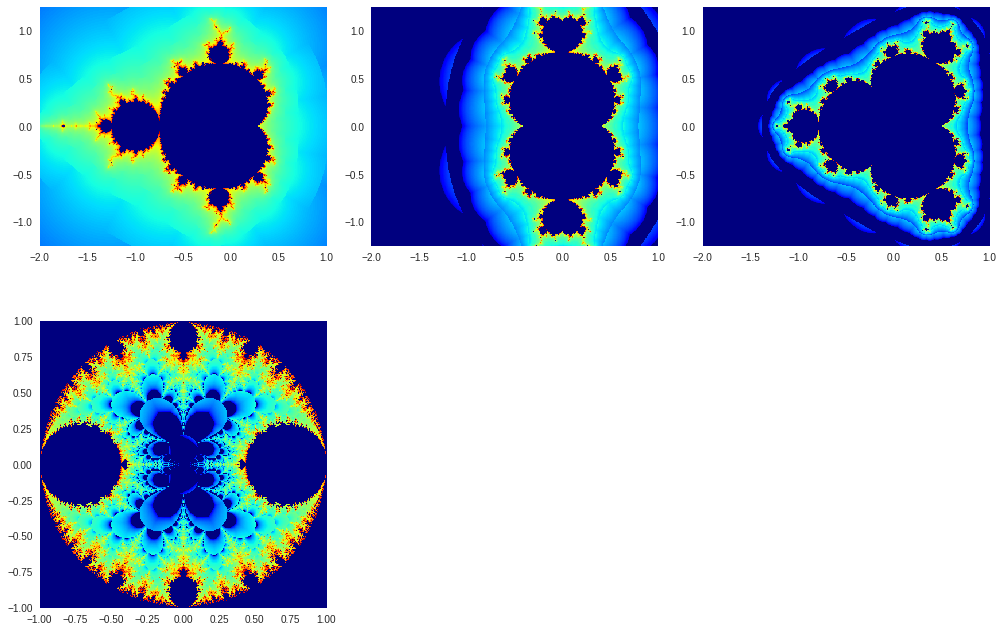

In [33]:
plt.figure(figsize=(14, 14))
for i, size in enumerate(range(2, 5)):
    mandel = mandelbrot(size, 60)
    plt.subplot(3, 3, i+1)
    plt.imshow(mandel.T, extent=[-2, 1, -1.25, 1.25], cmap='jet')
    plt.grid(False)

mbss = mandelbrot_sine(60)
plt.subplot(3, 3, 4)
plt.imshow(mbss.T, extent=[-1, 1, -1, 1], cmap='jet')
plt.grid(False)

plt.tight_layout()
plt.show()

In [45]:
print('Mandelbrot inefficient with color:')
%timeit mandelbrot(2, 50)

print('Mandelbrot sine inefficient with color:')
%timeit mandelbrot_sine(50)

Mandelbrot inefficient with color:
The slowest run took 7086881.21 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 283 ns per loop
Mandelbrot sine inefficient with color:
The slowest run took 29.53 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 107 ns per loop
